In [21]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
import cartopy.crs  as ccrs
import os
import datetime
from datetime import timedelta
from datetime import datetime
from matplotlib import ticker
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
import geopandas as gp
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D
from scipy import stats
from scipy.stats import linregress
import matplotlib.patches as patches

import WetBulb

GeoAxes._pcolormesh_patched = Axes.pcolormesh

In [22]:
def remove_time_mean(x):
    return x - x.mean(dim='time')

def standardize(x):
    return x/x.std(dim = 'time')

def CtoF(x):
    return x*9/5 + 32

In [23]:
def fix_lons(ds, lon_range=180):
    """
    This function fixes a few issues that show up when dealing with 
    longitude values. 
    
    Input: an xarray dataset, with a longitude dimension called "lon"
    
    Changes: 
    - The dataset is re-indexed to -180:180 or 0:360 longitude format, 
    depending on the subset_params['lon_range'] parameter
    - the origin (the first longitude value) is changed to the closest 
    lon value to subset_params['lon_origin'], if using a 0:360 range. 
    In other words, the range becomes [lon_origin:360 0:lon_origin]. 
    This is to make sure the subsetting occurs in the 'right' direction, 
    with the longitude indices increasing consecutively (this is to ensure
    that subsetting to, say, [45, 275] doesn't subset to [275, 45] or vice-
    versa). Set lon_origin to a longitude value lower than your first subset 
    value.
    """
    if lon_range==180:
    # Switch to -180:180 longitude if necessary
        if any (ds.longitude>180):
             ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180))
            
             # Change origin to half the world over, to allow for the 
             # longitude indexing to cross the prime meridian, but only
             # if the first lon isn't around -180 (using 5deg as an approx
             # biggest grid spacing). This is intended to move [0:180 -180:0]
             # to [-180:0:180].
             if ds.longitude[0] > -175:
                 ds = ds.roll(longitude=(ds.sizes['longitude'] // 2),roll_coords=True)
             elif lon_range==360:
                 # Switch to 0:360 longitude if necessary
                 ds = ds.assign_coords(longitude = ds.longitude % 360)
                 # Change origin to the lon_origin
                 ds = ds.roll(longitude=-((ds.longitude // subset_params['lon_origin'])==1).values.nonzero()[0][0],roll_coords=True)
    return ds

In [24]:
stn_folder = '/dx01/ivanov/data/HadISD_stationdata/brazil_heatwave/raw_station_data/'

# Rio stations
galeao_name = 'hadisd.3.4.0.2023f_19310101-20240101_837460-99999.nc'

galeao = xr.open_dataset(stn_folder + galeao_name)

# Open all data

### Temperature

In [25]:
file_dir = '/dx01/data/ERA5/2mtemp_dailymax/'

filenames = []

years_array = np.arange(1979,2023,1)

for year in years_array:
    
    if year <= 1958:
        
        file_name = file_dir + 'T_daily_max_ERA5_PBE_historical_an-sfc_' + str(year) + '_0UTC.nc'
    
    if year > 1958:
        
        file_name = file_dir + 'T_daily_max_ERA5_historical_an-sfc_' + str(year) + '_0UTC.nc'
        
    filenames.append(file_name)

# Open all files
temp_dailymax = xr.open_mfdataset(filenames)

In [26]:
temp_dailymax = temp_dailymax.rename_vars({'T': 't2m'})

In [27]:
# Just open 2023 data

file_dir = '/dx01/data/ERA5/2mtemp_dailymax/'

temp_2023 = xr.open_mfdataset(file_dir + 'T_daily_max_ERA5_historical_an-sfc_2023_0UTC.nc')

In [28]:
# Combine ERA5 and ERA5T
temp2023_ERA5 = temp_2023.sel(expver=1)

temp2023_ERA5T = temp_2023.sel(expver = 5)

In [29]:
temp2023_ERA5 = temp2023_ERA5.isel(time = slice(0, 304))
temp2023_ERA5T = temp2023_ERA5T.isel(time = slice(304,366))

In [30]:
temp2023_combined = xr.combine_by_coords([temp2023_ERA5,temp2023_ERA5T])

In [31]:
# Historical data
temp_combined = xr.combine_by_coords([temp_dailymax,temp2023_combined.drop_vars('expver')])

### Specific Humidity

In [32]:
dewpoint_file_dir = '/dx01/data/ERA5/2mdewpoint_dailymean/'
pressure_file_dir = '/dx01/data/ERA5/surface_pressure_dailymean/'

dewpoint_filenames = []
pressure_filenames = []

years_array = np.arange(1979,2023,1)

for year in years_array:
        
    dewpoint_file_name = dewpoint_file_dir + 'd2m_' + str(year) + '.nc'
    dewpoint_filenames.append(dewpoint_file_name)
    
    pressure_file_name = pressure_file_dir + 'sp_' + str(year) + '.nc'
    pressure_filenames.append(pressure_file_name)
    
# Open all files and calculate q
d2m_data = xr.open_mfdataset(dewpoint_filenames, parallel = True, combine = 'by_coords')
d2m_C = d2m_data.d2m - 273.15 #convert from kelvin

sp_data = xr.open_mfdataset(pressure_filenames, parallel = True, combine = 'by_coords')
sp_mb = sp_data/100

# Specific humidity
vap_pres = 6.112*np.exp((17.67*d2m_C)/(d2m_C + 243.5))
q = (0.622 * vap_pres)/(sp_mb.sp - (0.378 * vap_pres))
q_derived = q.to_dataset(name = 'q')

In [33]:
# Just open 2023 data
dewpoint_2023 = xr.open_dataset(dewpoint_file_dir + 'd2m_2023.nc')

dewpoint2023_ERA5 = dewpoint_2023.sel(expver = 1)
dewpoint2023_ERA5T = dewpoint_2023.sel(expver = 5)

dewpoint2023_ERA5 = dewpoint2023_ERA5.isel(time = slice(0, 334))
dewpoint2023_ERA5T = dewpoint2023_ERA5T.isel(time = slice(334,366))

dewpoint2023_combined = xr.combine_by_coords([dewpoint2023_ERA5,dewpoint2023_ERA5T])

In [34]:
# Using updated pressure data
pressure2023_combined = xr.open_dataset('/dx03/data/ERA5/temp/sp_2023.nc')

In [35]:
# Open all files and calculate q
d2m_C = dewpoint2023_combined.d2m - 273.15 #convert from kelvin
sp_mb = pressure2023_combined/100

# Specific humidity
vap_pres = 6.112*np.exp((17.67*d2m_C)/(d2m_C + 243.5))
q = (0.622 * vap_pres)/(sp_mb.sp - (0.378 * vap_pres))
q_derived_2023 = q.to_dataset(name = 'q')

In [36]:
q_derived_2023 = q_derived_2023.sortby('latitude')
q_derived = q_derived.sortby('latitude')

/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [37]:
# Historical data
q_combined = xr.combine_by_coords([q_derived,q_derived_2023.drop_vars('expver')])

### Z500

In [ ]:
file_dir = '/dx02/data/ERA5/geopotential_500hPa/'

filenames = []

years_array = np.arange(1979,2023,1)

for year in years_array:
        
    file_name = file_dir + 'geopotential_500hPa_daily_mean_global_' + str(year) + '.nc'
        
    filenames.append(file_name)

# Open all files
z500 = xr.open_mfdataset(filenames)

In [ ]:
# Just open 2023 data
file_dir = '/dx02/data/ERA5/geopotential_500hPa/'

z500_2023 = xr.open_mfdataset(file_dir + 'geopotential_500hPa_daily_mean_global_2023.nc')

In [ ]:
# Combine ERA5 and ERA5T
z500_2023_ERA5 = z500_2023.sel(expver=1)

z500_2023_ERA5T = z500_2023.sel(expver = 5)

In [ ]:
z500_2023_ERA5 = z500_2023_ERA5.where(z500_2023_ERA5.time.dt.month < 12 , drop = True)
z500_2023_ERA5T = z500_2023_ERA5T.where(z500_2023_ERA5T.time.dt.month == 12 , drop = True)

In [ ]:
z500_2023_combined = xr.combine_by_coords([z500_2023_ERA5,z500_2023_ERA5T])

In [ ]:
# Historical data
z500_combined = xr.combine_by_coords([z500,z500_2023_combined.drop_vars('expver')])

### Winds

In [ ]:
uwind_file_dir = '/dx01/data/ERA5/uwind_10m_dailymean/'
vwind_file_dir = '/dx01/data/ERA5/vwind_10m_dailymean/'

uwind_filenames = []
vwind_filenames = []

years_array = np.arange(1979,2023,1)

for year in years_array:
        
    uwind_file_name = uwind_file_dir + 'uwind_10m_' + str(year) + '.nc'
    uwind_filenames.extend([uwind_file_name])
    
    vwind_file_name = vwind_file_dir + 'vwind_10m_' + str(year) + '.nc'
    vwind_filenames.extend([vwind_file_name])

In [ ]:
# Open all files
uwind_dailymean = xr.open_mfdataset(uwind_filenames)
vwind_dailymean = xr.open_mfdataset(vwind_filenames)

In [ ]:
#### Just open 2023 data
uwind_2023 = xr.open_dataset(uwind_file_dir + 'uwind_10m_2023.nc')

uwind2023_ERA5 = uwind_2023.sel(expver=1)
uwind2023_ERA5T = uwind_2023.sel(expver = 5)

uwind2023_ERA5 = uwind2023_ERA5.sel(time = slice('01-01-2023','11-29-2023'))
uwind2023_ERA5T = uwind2023_ERA5T.sel(time = slice('11-30-2023','12-31-2023'))

uwind2023_combined = xr.combine_by_coords([uwind2023_ERA5,uwind2023_ERA5T])

In [ ]:
#### Just open 2023 data
vwind_2023 = xr.open_dataset(vwind_file_dir + 'vwind_10m_2023.nc')

vwind2023_ERA5 = vwind_2023.sel(expver=1)
vwind2023_ERA5T = vwind_2023.sel(expver = 5)

vwind2023_ERA5 = vwind2023_ERA5.sel(time = slice('01-01-2023','11-29-2023'))
vwind2023_ERA5T = vwind2023_ERA5T.sel(time = slice('11-30-2023','12-31-2023'))

vwind2023_combined = xr.combine_by_coords([vwind2023_ERA5,vwind2023_ERA5T])

In [ ]:
# Historical data
uwind_combined = xr.combine_by_coords([uwind_dailymean,uwind2023_combined.drop_vars('expver')])
vwind_combined = xr.combine_by_coords([vwind_dailymean,vwind2023_combined.drop_vars('expver')])

In [29]:
wind_mag = (uwind_combined.u10**2 + vwind_combined.v10**2)**(0.5)

In [30]:
def wind_uv_to_dir(U,V):
    """
    Calculates the wind direction from the u and v component of wind.
    Takes into account the wind direction coordinates is different than the 
    trig unit circle coordinate. If the wind directin is 360 then returns zero
    (by %360)
    Inputs:
      U = west/east direction (wind from the west is positive, from the east is negative)
      V = south/noth direction (wind from the south is positive, from the north is negative)
    """
    WDIR= (270-np.rad2deg(np.arctan2(V,U)))%360
    return WDIR

wind_angle = wind_uv_to_dir(uwind_combined.u10, vwind_combined.v10)

### SSTs

In [31]:
SSTs = xr.open_mfdataset('/dx01/data/OISST/raw/oisst-avhrr-v02r01.*')

In [32]:
SSTs_reg = SSTs.sel(lat = slice(-37,8), lon = slice(-75+360, -32+360)).mean(dim = ['zlev'])

### Precipitation

In [33]:
file_dir = '/dx01/data/ERA5/precip_dailytotal/'

filenames = []

years_array = np.arange(1979,2023,1)

for year in years_array:
        
    file_name = file_dir + 'precip_dailytotal_' + str(year) + '.nc'
        
    filenames.append(file_name)

# Open all files
precip = xr.open_mfdataset(filenames)

In [34]:
# Just open 2023 data
precip_2023 = xr.open_mfdataset(file_dir + 'precip_dailytotal_2023.nc')

In [35]:
# Combine ERA5 and ERA5T
precip_2023_ERA5 = precip_2023.sel(expver=1)

precip_2023_ERA5T = precip_2023.sel(expver = 5)

In [36]:
precip_2023_ERA5 = precip_2023_ERA5.where(precip_2023_ERA5.time.dt.month < 12 , drop = True)
precip_2023_ERA5T = precip_2023_ERA5T.where(precip_2023_ERA5T.time.dt.month == 12 , drop = True)

/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [37]:
precip_2023_combined = xr.combine_by_coords([precip_2023_ERA5,precip_2023_ERA5T])

In [38]:
# Historical data
precip_combined = xr.combine_by_coords([precip,precip_2023_combined.drop_vars('expver')])

### Soil Moisture

In [39]:
datadir1 = '/dx01/data/ERA5/volumetric_soil_water_layer1_dailymean/'
datadir2 = '/dx02/data/ERA5/volumetric_soil_water_layer1_dailymean/'

earlySM = xr.open_mfdataset(datadir1 + '*.nc')
lateSM = xr.open_mfdataset(datadir2 + 'swv_20*')

In [40]:
SM_combined = xr.combine_by_coords([earlySM,lateSM])

## Evaporation and Vertical Velocity

In [41]:
extra_data_dir = '/dx03/data/ivanov/Brazil_Heatwave_revisions/ERA5_data_for_time_evol/'

evap = xr.open_mfdataset(extra_data_dir + 'evaporation_*')

In [42]:
wwind = xr.open_mfdataset(extra_data_dir + 'vertical_velocity_*')

## Select Rio data and load

In [43]:
# Grid cell closest to Rio station location
lon_grid, lat_grid = np.meshgrid(temp_combined.longitude.values, temp_combined.latitude.values)
distances = np.sqrt((lon_grid - (galeao.longitude.values + 360))**2 + (lat_grid - galeao.latitude.values)**2)
min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

# Get the longitude and latitude of the closest grid cell
closest_lon = temp_combined.longitude.values[min_index[1]]
closest_lat = temp_combined.latitude.values[min_index[0]]

In [44]:
temp_rio = temp_combined.sel(latitude = [closest_lat], longitude = [closest_lon], time = slice('11-01-2023','11-30-2023')).mean(dim = ['latitude','longitude'])
q_rio = q_combined.sel(latitude = [closest_lat], longitude = [closest_lon], time = slice('11-01-2023','11-30-2023')).mean(dim = ['latitude','longitude'])
z500_rio = z500_combined.sel(latitude = [closest_lat], longitude = [closest_lon], time = slice('11-01-2023','11-30-2023')).mean(dim = ['latitude','longitude'])
precip_rio = precip_combined.sel(latitude = [closest_lat], longitude = [closest_lon], time = slice('11-01-2023','11-30-2023')).mean(dim = ['latitude','longitude'])
SM_rio = SM_combined.sel(latitude = [closest_lat], longitude = [closest_lon], time = slice('11-01-2023','11-30-2023')).mean(dim = ['latitude','longitude'])
sst_rio = SSTs_reg.sel(lat = slice(-24,-21), lon = slice(315, 318)).mean(dim = ['lat','lon'],skipna=True)
winds_rio = wind_mag.sel(latitude = [closest_lat], longitude = [closest_lon], time = slice('11-01-2023','11-30-2023')).mean(dim = ['latitude','longitude'])
wind_angle_rio = wind_angle.sel(latitude = [closest_lat], longitude = [closest_lon], time = slice('11-01-2023','11-30-2023')).mean(dim = ['latitude','longitude'])

In [58]:
wwind_rio = wwind.sel(latitude = [closest_lat], longitude = [closest_lon - 360], time = slice('11-01-2023','11-30-2023')).mean(dim = ['latitude','longitude'])
evap_rio = evap.sel(latitude = [closest_lat], longitude = [closest_lon - 360], time = slice('11-01-2023','11-30-2023')).mean(dim = ['latitude','longitude'])

In [60]:
# SSTs for gridcell closest to rio
lon_grid, lat_grid = np.meshgrid(SSTs_reg.lon.values, SSTs_reg.lat.values)
distances = np.sqrt((lon_grid - (galeao.longitude.values + 360))**2 + (lat_grid - galeao.latitude.values)**2)
min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

closest_lon_SST = SSTs_reg.lon.values[min_index[1]]
closest_lat_SST = SSTs_reg.lat.values[min_index[0]]

sst_rio = SSTs_reg.sel(lat = [closest_lat_SST], lon = [closest_lon_SST], time = slice('11-01-2023','11-30-2023')).mean(dim = ['lat','lon'])
sst_anom_rio = sst_rio.anom

In [61]:
wind_angle_rio_coast = wind_angle.sel(latitude = slice(-21,-24), longitude = slice(315, 318), time = slice('11-01-2023','11-30-2023')).mean(dim = ['latitude','longitude'])

In [62]:
temp_anom_rio = temp_rio['t2m'].groupby('time.dayofyear').apply(remove_time_mean)
q_anom_rio = q_rio['q'].groupby('time.dayofyear').apply(remove_time_mean)
z500_anom_rio = z500_rio['z'].groupby('time.dayofyear').apply(remove_time_mean)
precip_anom_rio = precip_rio['tp'].groupby('time.dayofyear').apply(remove_time_mean)
SM_anom_rio = SM_rio['swvl1'].groupby('time.dayofyear').apply(remove_time_mean)
sst_anom_rio = sst_rio.anom
winds_anom_rio = winds_rio.groupby('time.dayofyear').apply(remove_time_mean)

In [ ]:
# Save intermediate data for each one
save_dir = '/dx02/data/ivanov/data/ERA5/Brazil_Heatwave/'

# Magnitude
temp_rio.to_netcdf(save_dir + 'temp_mag_rio_november2023.nc')
q_rio.to_netcdf(save_dir + 'q_mag_rio_november2023.nc')
z500_rio.to_netcdf(save_dir + 'z500_mag_rio_november2023.nc')
precip_rio.to_netcdf(save_dir + 'precip_mag_rio_november2023.nc')
SM_rio.to_netcdf(save_dir + 'SM_mag_rio_november2023.nc')
sst_rio.to_netcdf(save_dir + 'sst_mag_rio_november2023.nc')
winds_rio.to_netcdf(save_dir + 'winds_mag_rio_november2023.nc')
wind_angle_rio.to_netcdf(save_dir + 'wind_angle_rio_november2023.nc')
wind_angle_rio_coast.to_netcdf(save_dir + 'wind_angle_rio_coast_november2023.nc')

# Anomaly
temp_anom_rio.to_netcdf(save_dir + 'temp_anom_rio_november2023.nc')
q_anom_rio.to_netcdf(save_dir + 'q_anom_rio_november2023.nc')
z500_anom_rio.to_netcdf(save_dir + 'z500_anom_rio_november2023.nc')
precip_anom_rio.to_netcdf(save_dir + 'precip_anom_rio_november2023.nc')
SM_anom_rio.to_netcdf(save_dir + 'SM_anom_rio_november2023.nc')
sst_anom_rio.to_netcdf(save_dir + 'sst_anom_rio_november2023.nc')
winds_anom_rio.to_netcdf(save_dir + 'winds_anom_rio_november2023.nc')

In [17]:
save_dir = '/dx02/data/ivanov/data/ERA5/Brazil_Heatwave/'
wwind_rio.to_netcdf(save_dir + 'verticalwind_500hPa_rio_november2023.nc')

In [17]:
save_dir = '/dx02/data/ivanov/data/ERA5/Brazil_Heatwave/'
evap_rio.to_netcdf(save_dir + 'evaporation_dailymean_rio_november2023.nc')

In [8]:
sst_rio = SSTs_reg.sel(lat = slice(-24,-21), lon = slice(315, 318)).mean(dim = ['lat','lon'],skipna=True)
sst_anom_rio = sst_rio.anom

In [26]:
save_dir = '/dx02/data/ivanov/data/ERA5/Brazil_Heatwave/'
sst_rio.to_netcdf(save_dir + 'sst_rio_gridcell_november2023.nc')

/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


### Save magnitude of each variable for rio gridcell, 1979-2023

In [65]:
temp_rio = temp_combined.sel(latitude = [closest_lat], longitude = [closest_lon]).mean(dim = ['latitude','longitude'])
q_rio = q_combined.sel(latitude = [closest_lat], longitude = [closest_lon]).mean(dim = ['latitude','longitude'])
z500_rio = z500_combined.sel(latitude = [closest_lat], longitude = [closest_lon]).mean(dim = ['latitude','longitude'])
precip_rio = precip_combined.sel(latitude = [closest_lat], longitude = [closest_lon]).mean(dim = ['latitude','longitude'])
SM_rio = SM_combined.sel(latitude = [closest_lat], longitude = [closest_lon]).mean(dim = ['latitude','longitude'])
sst_rio = SSTs_reg.sel(lat = slice(-24,-21), lon = slice(315, 318)).mean(dim = ['lat','lon'],skipna=True).sst
winds_rio = wind_mag.sel(latitude = [closest_lat], longitude = [closest_lon]).mean(dim = ['latitude','longitude'])
wind_angle_rio = wind_angle.sel(latitude = [closest_lat], longitude = [closest_lon]).mean(dim = ['latitude','longitude'])

In [207]:
wwind_rio = wwind.sel(latitude = [closest_lat], longitude = [closest_lon -360]).mean(dim = ['latitude','longitude'])
evap_rio = evap.sel(latitude = [closest_lat], longitude = [closest_lon -360]).mean(dim = ['latitude','longitude'])

In [208]:
save_dir = '/dx03/data/ivanov/Brazil_Heatwave_revisions/'

wwind_rio.to_netcdf(save_dir + 'wwind_mag_rio_1979-2023.nc')
evap_rio.to_netcdf(save_dir + 'evaporation_mag_rio_1979-2023.nc')

In [67]:
# Save intermediate data for each one
save_dir = '/dx03/data/ivanov/Brazil_Heatwave_revisions/'

# Magnitude
temp_rio.to_netcdf(save_dir + 'temp_mag_rio_1979-2023.nc')
q_rio.to_netcdf(save_dir + 'q_mag_rio_1979-2023.nc')
z500_rio.to_netcdf(save_dir + 'z500_mag_rio_1979-2023.nc')
precip_rio.to_netcdf(save_dir + 'precip_mag_rio_1979-2023.nc')
SM_rio.to_netcdf(save_dir + 'SM_mag_rio_1979-2023.nc')
sst_rio.to_netcdf(save_dir + 'sst_mag_rio_1981-05312024.nc')
winds_rio.to_netcdf(save_dir + 'winds_mag_rio_1979-2023.nc')
wind_angle_rio.to_netcdf(save_dir + 'wind_angle_rio_1979-2023.nc')

/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


# Load preprocessed data

In [38]:
# Open magnitude and anomaly data
data_dir = '/dx02/data/ivanov/data/ERA5/Brazil_Heatwave/'
data_dir2 = '/dx03/data/ivanov/Brazil_Heatwave_revisions/'

temp_fullperiod = xr.open_dataset(data_dir2 + 'temp_mag_rio_1979-2023.nc')
q_fullperiod = xr.open_dataset(data_dir2 + 'q_mag_rio_1979-2023.nc')
z500_fullperiod = xr.open_dataset(data_dir2 + 'z500_mag_rio_1979-2023.nc')
precip_fullperiod = xr.open_dataset(data_dir2 + 'precip_mag_rio_1979-2023.nc')
SM_fullperiod = xr.open_dataset(data_dir2 + 'SM_mag_rio_1979-2023.nc')
SST_fullperiod = xr.open_dataset(data_dir2 + 'sst_mag_rio_1981-05312024.nc')
winds_fullperiod = xr.open_dataset(data_dir2 + 'winds_mag_rio_1979-2023.nc')
wind_angle_fullperiod = xr.open_dataset(data_dir2 + 'wind_angle_rio_1979-2023.nc')

wwind_fullperiod = xr.open_dataset(data_dir2 + 'wwind_mag_rio_1979-2023.nc')
evap_fullperiod = xr.open_dataset(data_dir2 + 'evaporation_mag_rio_1979-2023.nc')

In [39]:
# Plot full month of November 2023
days_before = 17
days_after = 12

dates = [datetime(2023,11,18)]

In [40]:
ticks = ['-14','-7','0','7']
marker='o'
markersize = 7

for i, date in enumerate(dates):

    start_date = date - timedelta(days = days_before)
    end_date = date + timedelta(days = days_after)

    temp_toplot = temp_fullperiod.sel(time = slice(start_date, end_date))
    q_toplot = q_fullperiod.sel(time = slice(start_date, end_date))
    z500_toplot = z500_fullperiod.sel(time = slice(start_date, end_date))
    precip_toplot = precip_fullperiod.sel(time = slice(start_date, end_date))
    SM_toplot = SM_fullperiod.sel(time = slice(start_date, end_date))
    SST_toplot = SST_fullperiod.sel(time = slice(start_date, end_date))
    winds_toplot = winds_fullperiod.sel(time = slice(start_date, end_date))
    wind_angle_toplot = wind_angle_fullperiod.sel(time = slice(start_date, end_date))
    wwind_toplot = wwind_fullperiod.sel(time = slice(start_date, end_date))
    evap_toplot = evap_fullperiod.sel(time = slice(start_date, end_date))

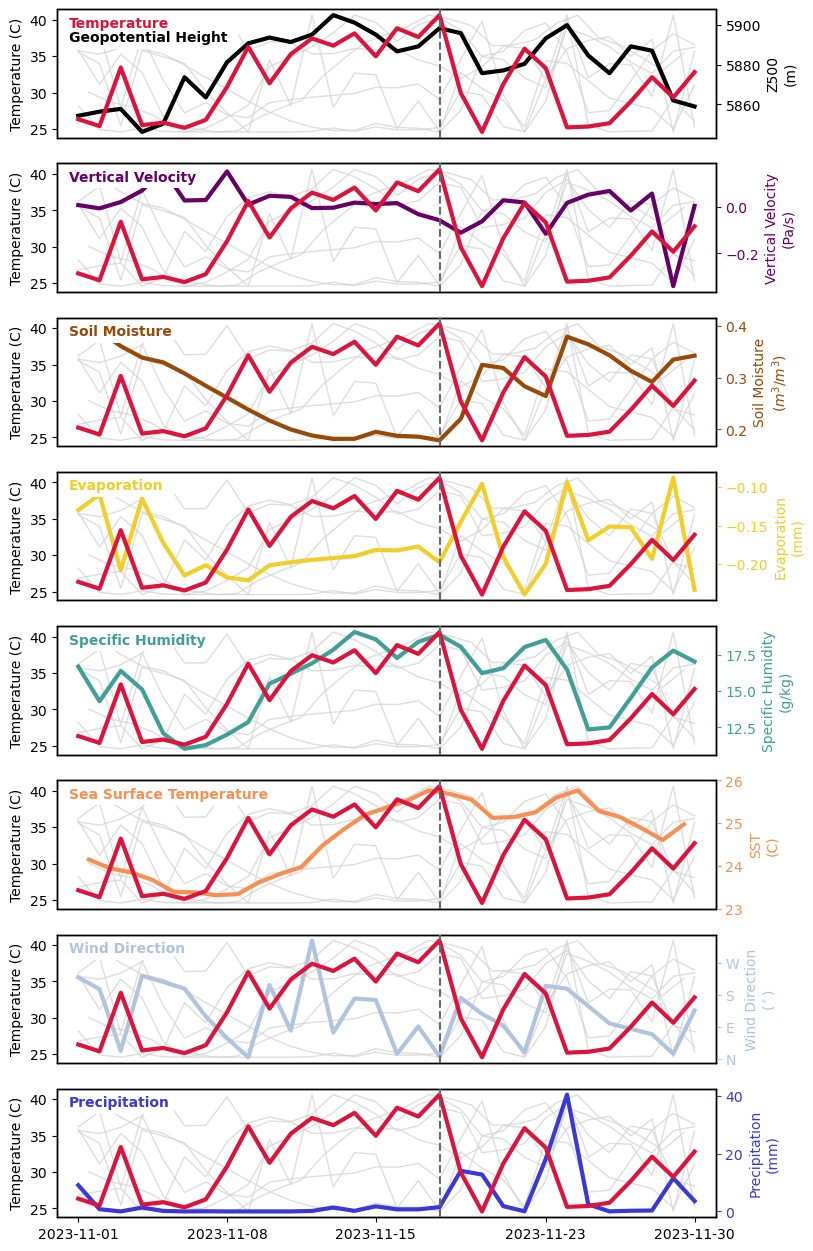

In [41]:
comparison_data = [z500_toplot.z/9.81,wwind_toplot.w,SM_toplot.swvl1,1000*evap_toplot.e,1000*q_toplot.q, SST_toplot.sst, wind_angle_toplot.v10, 1000*precip_toplot.tp]
labels = ['Z500\n(m)','Vertical Velocity\n(Pa/s)','Soil Moisture\n($m^3$/$m^3$)','Evaporation\n(mm)','Specific Humidity\n(g/kg)', 'SST\n(C)', 'Wind Direction\n($^\circ$)', 'Precipitation\n(mm)']
colors = ['k','#660066','#974907','#f2ce2b','#429f97','#f99053','lightsteelblue','#3939d8']

titles = ['Geopotential Height','Vertical Velocity','Soil Moisture','Evaporation','Specific Humidity','Sea Surface Temperature','Wind Direction','Precipitation']
yticks_angles = ['N','E','S','W']
xticks = ['11-01-2023','11-08-2023','11-15-2023','11-23-2023','11-30-2023']
marker = 'o'
markersize = 7
primary_linewidth = 3
primary_color = 'crimson'
back_linewidth = 1
back_color = 'lightgrey'

fig, axs = plt.subplots(8,1, figsize = (8.5,16), dpi = 100)

for i, ax in enumerate(fig.axes):
    
    # Plot temperature curve
    temp_series = ax.plot(temp_toplot.time, temp_toplot.t2m - 273.15, c = primary_color, linewidth = primary_linewidth)
    ax.set_ylabel('Temperature (C)')
    ax.axvline(x = datetime(2023, 11, 18), color = 'dimgrey', linestyle = 'dashed',  linewidth = 1.5)
    
    if i == 0:
        ax.text(datetime(2023, 10, 31,13),39,'Temperature', color = primary_color, fontweight = 'bold')
        ax.text(datetime(2023, 10, 31,13),37, titles[i], color = colors[i], fontweight = 'bold')
    else:
        ax.text(datetime(2023, 10, 31,13),39,titles[i], color = colors[i], fontweight = 'bold') 
  
    # Plot all curves in background
    for j, dataset in enumerate(comparison_data):

        ax2 = ax.twinx()
        back_series = ax2.plot(dataset.time, dataset, c = back_color, linewidth = back_linewidth, alpha = 0.75)
        ax2.set_yticks([])

    # Plot comparison curve
    data = comparison_data[i]
    ax3 = ax.twinx()
    comparison_series = ax3.plot(data.time, data, c = colors[i], linewidth = primary_linewidth)

    ax3.set_ylabel(labels[i], c=colors[i])
    ax3.tick_params(axis='y', colors=colors[i])
        
    ax.set_zorder(1)  # default zorder is 0 for ax1 and ax2
    ax.set_frame_on(False)  # prevents ax1 from hiding ax2
    
    if i == 0 :
        rect = patches.Rectangle((datetime(2023, 10, 31,12),36),timedelta(days = 8), 5, facecolor='white')
        ax.add_patch(rect)    
    if i == 1:
        rect = patches.Rectangle((datetime(2023, 10, 31,12),38),timedelta(days = 6), 3, facecolor='white')
        ax.add_patch(rect)
    if i > 1:
        rect = patches.Rectangle((datetime(2023, 10, 31,12),38),timedelta(days = 5), 3, facecolor='white')
        ax.add_patch(rect)
    if i == 5:
        rect = patches.Rectangle((datetime(2023, 10, 31,12),38),timedelta(days = 10), 3, facecolor='white')
        ax.add_patch(rect)
        
    # Set xticks appropriately
    if i == 7:
        ax.set_xticks([datetime(2023, 11, 1),datetime(2023, 11, 8),datetime(2023, 11, 15),datetime(2023, 11, 23),
                       datetime(2023, 11, 30)])
    else:
        ax.set_xticks([])
        
    # Set yticks for wind angle
    if i == 6:
        ax3.set_yticks(([0,90,180,270]))
        ax3.set_yticklabels(yticks_angles)
        
    # Set yticks for SSTs
    if i == 5:
        ax3.set_yticks([23,24,25,26])

    ax.set_xlim([datetime(2023, 10, 31),datetime(2023, 12, 1)])

#plt.savefig('Figure5.png')

plt.show()